# Import packages

In [1]:
import glob
import imageio
import pandas as pd
import os
import re
import numpy as np

from tqdm import tqdm
from tqdm import tnrange
from collections import defaultdict

# Data Load

In [2]:
folder_path = '/home/ubunt/wav2mid/data/cnn inputs/*'

In [3]:
remove_len = len(folder_path) - 1
remove_len

36

In [4]:
# 폴더(음 조합)의 개수
a=glob.glob(folder_path + "*")
len(a)

6746

In [5]:
# Y_list : one-hot 처리된 라벨링 정보
Y_list=[]
list88=[str(i) for i in range(21,109)]

for i in tnrange(len(a)):
    Y=np.zeros(len(list88))
    find=re.findall("[0-9]+", str(a[i][remove_len:])) #i번 폴더의 이름에 들어가는 숫자를 전부 추출
    for k in range(len(find)):
        Y[list88.index(find[k])]=1

    for _ in glob.glob(a[i]+"/*.jpg"):
        Y_list.append(Y)

In [6]:
# 이미지 가져오기
val_list=[]
dataset = []
cnt_list = []
name_list = []

for i in tnrange(len(a)):
    classes=[]
    # image load
    for image_path in glob.glob(a[i]+"/*.jpg"):
        im = imageio.imread(image_path)
        dataset.append(im)
        classes.append(im)
        
    # 변수 할당 val_list_50 = 라벨 50
    globals()['val_list_' + str(a[i][remove_len:])] = classes
    val_list.append(globals()['val_list_' + str(a[i][remove_len:])])
    
    # name_list, cnt_list : cnt_dict를 위함
    name_list.append('val_list_' + a[i][remove_len:])
    cnt_list.append(len(dataset))

In [7]:
# cnt_dict : 나중에 dbscan에서 제거할 애들을 위한 index dictionary
cnt_dict = {'val_list_' + a[0][remove_len:] : 0}
for i in range(1,len(name_list)) :
    cnt_dict[name_list[i]] = cnt_list[i-1]

In [8]:
# image shape
print(val_list[0][1].shape)
# label cnt
len(val_list)

(224, 224, 3)


6746

# KNN

#### KNN을 이용하여 빈번하게 사용되지 않는 음을 가장 유사한 main 음으로 할당하였다.

In [9]:
# 각 폴더의 이미지 개수
val_len_list=[len(val_list[i]) for i in range(len(val_list))]

In [10]:
# unique 라벨
class_list = []
for i in range(len(val_list)) :
    class_list.append(a[i][remove_len:])
print(class_list[:6])

['64_67_82', '48_56', '51_54_58_63_70_75_78_82', '47_62_66_71', '46_58_86', '42_51']


In [11]:
# 폴더별 데이터 개수를 파악하기 위한 data frame
df = pd.DataFrame({'음': class_list,'갯수': val_len_list})

In [12]:
# 시각화
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.barplot(x='음', y='갯수', data=df.iloc[:10,:])

In [13]:
# 다른 클래스에 할당되는 기준 
freq_crit = 2
# 눌린 음 경우의 수에 따라 기준을 달리 적용해야하는 것 고려 * 

In [14]:
# 확인
df.iloc[0:2] 

,음,갯수
0,64_67_82,16
1,48_56,3


In [15]:
main=list(df[df['갯수'] >= freq_crit]['음']) # 클래스로 남을 "음"
sub=list(df[df['갯수'] < freq_crit]['음'])  # 흡수될 음

main_index=list(df[df['갯수'] >= freq_crit]['음'].index) # 클래스로 남을 "음"의 인덱스
sub_index=list(df[df['갯수'] < freq_crit]['음'].index)  # 흡수될 음의 인덱스 

In [16]:
# 기준별 main과 sub의 개수
print(len(main),len(sub))

## 전체 이미지 개수 대비 하위 n% 기준으로 삼아서 날려야 할 것 같음.
## 기준에 대한 보완 필요
## KNN은 모델의 성능에 어느정도 영향을 미치는지 파악하기 위함, 다음과 같이 해석하면 될 것 같음
## 좋게 나온다면 : 적은 데이터로 비슷한 성능을 통해 보다 빠른 학습 및 knn시사점 발견
## 나쁘게 나온다면 : multi label classification은 sigmoid를 사용하기에 각각의 분류기를 구축함에 있어 데이터 손실의 영향

3705 3041


#### KNN은 알고리즘 특성상 연산을 할 때 많은 메모리 및 연산비용이 크다.

#### 따라서 모든 데이터간의 거리를 연산하지 않고 각 라벨의 평균을 대표값으로 취하여 적용하였다.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from PIL import Image  

In [19]:
mean_list=[]
for k in tnrange(len(val_list)): #폴더의 갯수만큼 반복
    n_component=len(val_list[k])
    # np.array로 바꿔서 연산(이미지 format은 ~255까지만 표현가능하여 합연산이 적용되지 않음)
    mean=np.array(val_list[k][0].copy(),dtype=np.int32)

    # 각 라벨의 평균 적용
    for i in range(1,n_component):
        mean=mean+np.array(val_list[k][i].copy()) 

    mean=mean/n_component 
    mean=(mean.round())
    mean=np.array(mean.copy(),dtype=np.uint8)
    #mean=Image.fromarray(mean,"RGB") # 다시 이미지로 변환
    mean_list.append(mean)

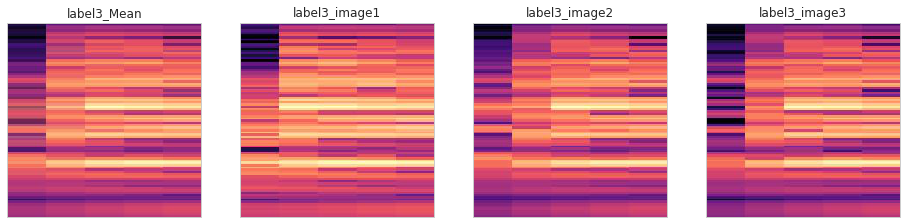

In [20]:
# 대표걊 확인
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={'xticks': [], 'yticks': []})
axes[0].set_title("label3_Mean")
axes[0].imshow(mean_list[3], interpolation='nearest')
axes[1].set_title("label3_image1")
axes[1].imshow(val_list[3][0], interpolation='nearest')
axes[2].set_title("label3_image2")
axes[2].imshow(val_list[3][1], interpolation='nearest')
axes[3].set_title("label3_image3")
axes[3].imshow(val_list[3][2], interpolation='nearest')
plt.show()

In [21]:
# 거리 계산 함수, 유클리드 거리
def calculateDistance(i1, i2):
    return np.sum((i1-i2)**2)

In [22]:
# KNN 적용
# sub -> main 으로 할당
change_class_list=a.copy()
cnt = 0
for n in sub_index: ###타켓을 서브 안에서 뽑는다.
    which_min = []
    target = class_list[n]
    main_cp_list=[]
    sub_cp=re.findall("[0-9]+", class_list[n])

    for i in main_index:
        # label의 '_'제거, main_cp = [32,56]
        main_cp=re.findall("[0-9]+", class_list[i])
        
        # main이 sub의 부분집합인 경우 append
        if len(set(main_cp) - set(sub_cp)) == 0 :
            main_cp_list.append(class_list[i]) # class_list = "32_56"
                    
    # 위 조건을 충족한 main들의 class_list안에서의 index정보 추출
    main_cp_index=[]
    for k in range(len(main_cp_list)):
        main_cp_index.append(class_list.index(main_cp_list[k])) # class_list에서 main_cp_list[k]값을 갖고 있는 위치

    # 모든 main class와의 거리 측정
    for t in main_cp_index:
        which_min.append(calculateDistance(mean_list[n],mean_list[t]))

    cnt += 1
    # 가장 가까운 유클리드 거리를 갖는 class로 할당
    for q in range(len(main_cp_index)) :
        if which_min[q] == min(which_min) :
            change_class_list[n]=a[main_index[q]]
            if cnt % 50 == 0 :
                print(target,"Subscribe to",class_list[main_cp_index[q]])

43_48_55_63_67 Subscribe to 43_55_67
41_48_53 Subscribe to 41_53
44_49_53_61 Subscribe to 49_53_61
44_60_63_66 Subscribe to 60_66
44_56_84_88 Subscribe to 44_56
75_78_81_90 Subscribe to 75_78
68_76 Subscribe to 68
36_48_63_68_75 Subscribe to 36_48
65_68_74_77_80_86 Subscribe to 65_68_74
54_58_65 Subscribe to 54_58
52_64_80_88_92 Subscribe to 64_80
62_78_90 Subscribe to 78
58_61_63_67_70_77 Subscribe to 61_67_70_77
58_65_68_70_74_76 Subscribe to 65_76
67_71_79_86 Subscribe to 67_71_79
54_66_70_78_82 Subscribe to 54_66_70_78
33_75 Subscribe to 33
64_69_72_77 Subscribe to 72_77
51_63_73_80_85 Subscribe to 51_63
53_59_65_71_77_83 Subscribe to 53_65
42_54_69 Subscribe to 42_54
65_92 Subscribe to 92
32_44_78_87 Subscribe to 32_78
25_37_56_61_65_68 Subscribe to 25_37
58_61_65_70_82 Subscribe to 65_82
49_80_89 Subscribe to 49_80
58_70_77 Subscribe to 70_77
49_53_56_65_68 Subscribe to 53_56_68
50_53_65 Subscribe to 53_65
49_52_58 Subscribe to 49_58
44_51_58_61 Subscribe to 44_61
47_54_59_66_71 

In [23]:
# 라벨 폴더에 해당 라벨링에 해당되는 이미지 데이터들이 들어있으므로 
# ImageGenerator를 통해 쉽게 train 데이터를 형성할 수 있지만,
# KNN을 통해 sub 라벨링으로 지정된 폴더들을 main 라벨링 폴더로 옮겨줄려면 실제 물리적으로 데이터들을 옮겨야하는 수고가 발생한다. 
# 따라서 dataset(이미지 데이터):Y_list(데이터의 라벨링 정보) 페어를 만들어서 
# Y_list의 정보만 knn이 적용된 change_Y_list로 갱신해주면 
# 메모리 작업 없이 가상으로 폴더들을  물리적으로 옮긴 것과 똑같은 결과를 낼 수 있다.

change_Y_list=[] #knn이 적용된 라벨링 정보

for i in range(len(change_class_list)):
    Y=np.zeros(len(list88))
    find=re.findall("[0-9]+", change_class_list[i][remove_len:])  
    for k in range(len(find)):
        Y[list88.index(find[k])] = 1
    for i in range(val_len_list[i]):
        change_Y_list.append(Y)

print(len(change_Y_list))

58291


In [24]:
val_list[1][0].shape #1번 폴더의 0번 사진.

(224, 224, 3)

In [25]:
np.array(val_list[3]).shape

(3, 224, 224, 3)

# PCA

- PCA를 통해 2개의 주성분으로 축소한다. 그 후 DBSCAN을 이용하여 이상치를 제거한다.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## make_imageForm : 리스트 형태의 데이터를 (n, 224,224,3)으로 변환하는 함수
def make_imageForm(x) :
    tmp = np.zeros((len(x),224,224,3))
    for i in range(len(tmp)) :
        tmp[i] = x[i]
    return(tmp)

## output_pca : 위 이미지 형태(n, 224, 224, 3)의 데이터를 pd.DataFrame으로 바꾸는 함수
def output_pca(x) :
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    x.resize(x.shape[0],224*224*3)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    return(principalDf)

## plot_pca : 데이터 프레임에서 pca결과를 그래프로 그리는 함수
def plot_pca(x):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    ax.scatter(x.loc[:, 'principal component 1']
               , x.loc[:, 'principal component 2']
               , c = "black")
    ax.grid()
    
## plot_pca_label : label별로 plot색 다르게
def plot_pca_label(x) :
    label = x['label']
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    ax.scatter(x.loc[:, 'principal component 1']
               , x.loc[:, 'principal component 2']
               , c = label)
    ax.grid()
    
## output_pca를 통해 나온 데이터가 x로 들어간다.
def norm_scale(x) : # Quantile transform
    from sklearn.preprocessing import QuantileTransformer
    ## 스케일링
    data = QuantileTransformer(output_distribution='normal').fit_transform(x)
    data_norm = pd.DataFrame(data,columns = ['principal component 1', 'principal component 2'])
    return(data_norm)

def norm_scale2(x) : # Standard transform
    from sklearn.preprocessing import StandardScaler
    ## 스케일링
    data = StandardScaler().fit_transform(x)
    data_norm = pd.DataFrame(data,columns = ['principal component 1', 'principal component 2'])
    return(data_norm)

## norm_scale을 거친 데이터가 x로 들어간다.
def dbscan_norm(x, eps = 0.5, min_samples = 5) :
    from sklearn.cluster import DBSCAN
    ## dbscan 적용
    db = DBSCAN(eps=eps, min_samples=min_samples)
    clustering = db.fit(np.array(x))
    print('군집 수 : ',len(set(clustering.labels_)))
    return(clustering)

## nrom_scale을 거친 데이터가 data, cluster는 dbscan_norm을 거친 결과가 cluster
def dbscan_plot(data, cluster) :
    labels = pd.DataFrame({'label' : cluster.labels_})
    data = data
    data = pd.concat([data, labels], axis=1)
    if data.shape[1] == 3 :
        print('Complete')
    plot_pca_label(data)

In [27]:
# 40번 음을 실제로 시각화

In [28]:
imgs_40 = make_imageForm(val_list_40)
imgs40_pca = output_pca(imgs_40)

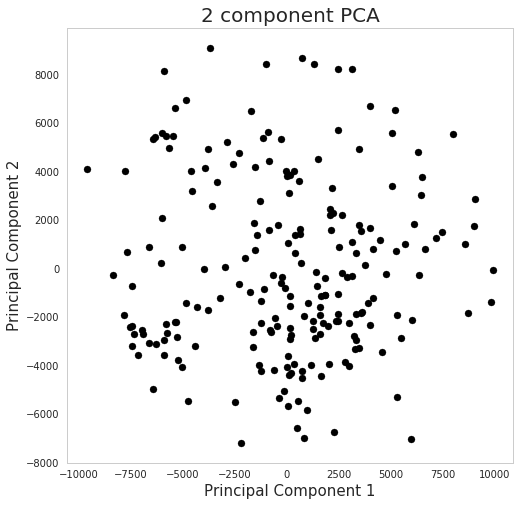

In [29]:
plot_pca(imgs40_pca)

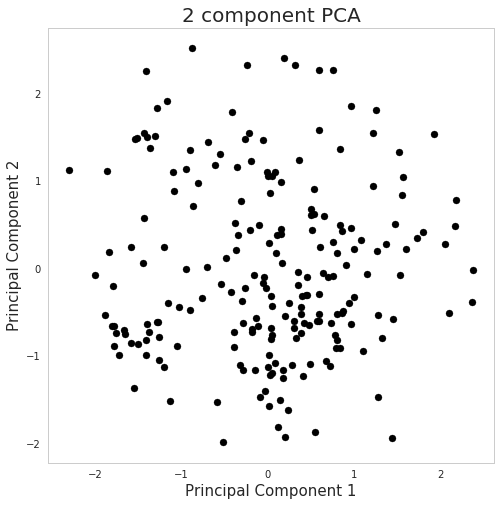

In [30]:
## 정규분포로 스케일링
imgs40_pca_norm = norm_scale2(imgs40_pca)
plot_pca(imgs40_pca_norm)

# DBSCAN

시각화로 다음과 같이 3가지를 시범 적용하였다.

- eps : 1, min_samples = 5
- eps : 0.4, min_samples = 5
- eps : 0.5, min_samples = 5

이후 최대 군집안에서 core sample만 활용하고 나머지는 이상치로 판단 후 제거한다.

In [31]:
from sklearn.cluster import DBSCAN

In [32]:
df.describe()

,갯수
count,6746.000000
mean,8.640824
std,55.706890
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,1138.000000


In [33]:
df_dbscan = df[df['갯수'] > 199].sort_values('갯수', ascending = False)
df_dbscan.tail()

,음,갯수
2340,87,290
367,88,282
498,85,271
4495,91,220
4182,40,211


군집 수 :  1
Complete


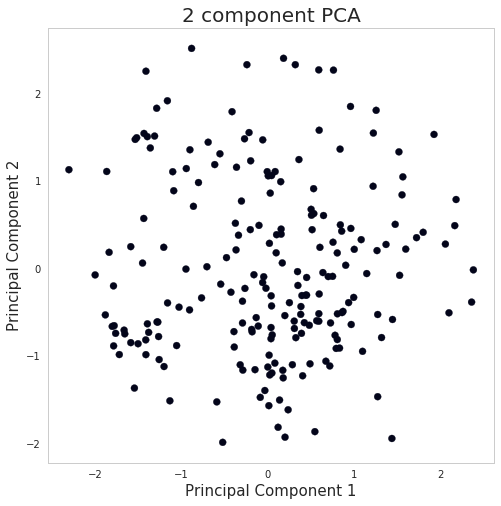

In [34]:
## DBSCAN 적용, eps : 1, min_samples = 5
clustering = dbscan_norm(imgs40_pca_norm, eps = 1)
## plot
dbscan_plot(imgs40_pca_norm,clustering)

군집 수 :  3
Complete


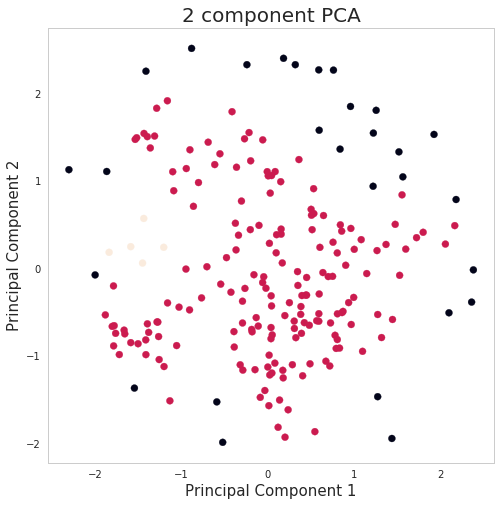

In [35]:
## DBSCAN 적용, eps : 0.4, min_samples = 5
clustering = dbscan_norm(imgs40_pca_norm, eps = 0.4)
## plot
dbscan_plot(imgs40_pca_norm,clustering)

군집 수 :  2
Complete


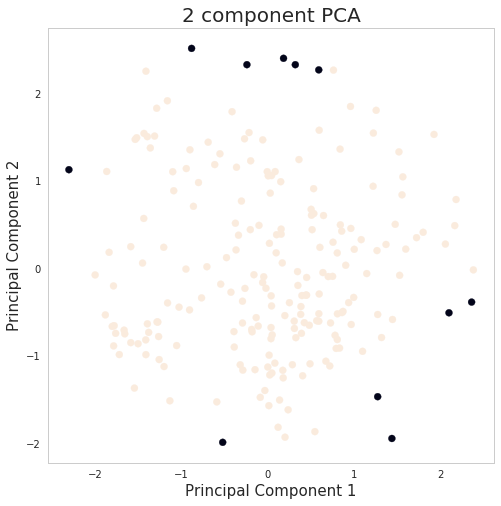

In [36]:
## DBSCAN 적용, eps : 0.5, min_samples = 5
clustering = dbscan_norm(imgs40_pca_norm)
## plot
dbscan_plot(imgs40_pca_norm,clustering)

In [37]:
## x는 dbscan_norm를 거친 clustering 데이터
## data는 norm_scale를 거친 아웃풋
## 코어데이터를 뽑아내는 과정
def extract_coreidx(x, data) :
    labels = pd.DataFrame({'label' : x.labels_})
    data =pd.concat([data, labels], axis=1)
    core_sample = x.core_sample_indices_
    row_idx = pd.DataFrame({'index' : data.axes[0].tolist()})
    tmp_data =pd.concat([row_idx, data], axis=1)
    
    ## 할당된 군집에서 제일 많은 개수를 갖는 군집을 선택함.
    cluster_count = []
    max_label = []
    for i in set(x.labels_) :
        cluster_count.append(tmp_data[tmp_data['label'] == i].shape[0])
    for i,_ in enumerate(cluster_count) :
        if max(cluster_count) == cluster_count[i] :
            #print('max label은 ', i)
            max_label = i
            
    max_label_data = tmp_data[tmp_data['label'] == max_label]
    
    ## 중심부 클러스터의 core_data
    check_list = []
    for i in range(max_label_data['index'].shape[0]) :
        if np.array(max_label_data['index'])[i] in core_sample : 
            check_list.append(i)
    return(check_list)

In [38]:
# check1은 core sample의 인덱스이다.
check1 = extract_coreidx(clustering, imgs40_pca_norm)
print(len(check1))

183


In [39]:
# index_list = 전체 index(data_set, change_Y_list) 중 해당 음의 index
index_list = [x + cnt_dict['val_list_' + str(40)] for x in range(len(val_list_40))]
# core_index_list = 전체 index(data_set, change_Y_list) 중 해당 음의 core index
core_index_list = [x + cnt_dict['val_list_' + str(40)] for x in check1]
# pop_list = 전체 index(data_set, change_Y_list) 중 해당 음의 제거되는 index
pop_list = [x for x in index_list if x not in core_index_list]

In [40]:
def delete_outlier(data,index) :
    main = [data[x] for x in index]
    return main

In [41]:
# 이상치 제거 후 core data
new = delete_outlier(val_list_40, check1)

In [42]:
# 이상치 제거 전 데이터 개수
print("이상치 제거 전 데이터 개수 :",len(val_list_40))
# 이상치 제거 후 데이터 개수
print("이상치 제거 후 데이터 개수 :",len(new))

이상치 제거 전 데이터 개수 : 211
이상치 제거 후 데이터 개수 : 183


### 위 과정을 n(200)개 이상을 가진 음에 동시 적용

In [43]:
def make_output(number, norms = "Standard", eps = 0.5, min_samples = 5) :
    # 변수 선택 및 이미지 변환
    imgs = make_imageForm(globals()["val_list_" + str(number)])
    imgs_pca = output_pca(imgs) # plot_pca input before norm scale
    
    # norm 스케일링
    if norms in ['Standard', 0] :
        imgs_pca_norm = norm_scale2(imgs_pca) # plot_pca input after Standard norm scale
    else :
        imgs_pca_norm = norm_scale(imgs_pca) # plot_pca input after Quantile norm scale
    
    # dbscan plot을 위한 clustering
    clustering = dbscan_norm(imgs_pca_norm, eps, min_samples) # for dbscan plot
    
    # 최대 군집의 비율이 전체의 90% 이상이면 변수 return
    labels_prop = []

    for labels in list(set(clustering.labels_)) :
        labels_prop.append(np.sum(clustering.labels_ == labels)/len(clustering.labels_))
    
    if labels_prop[0] >= 0.9 : 
        print("최다 군집의 전체 대비 비율 :", labels_prop[0])
        return imgs_pca, imgs_pca_norm, clustering
    
    else :
        print("eps / min_samples를 조정하세요")
        return False, False, False
    
def apply_dbscan(n) :
    # 원하는 개수 이상의 음만 사용
    df_dbscan = df[df['갯수'] >= n].sort_values('갯수', ascending = False)
    
    # pop_output : apply_dbscan의 output으로 제거되는 list의 모음
    pop_output = []
    # 각 음을 돌면서 imgs_pca : 이미지 변환 및 pca 적용, imgs_n_pca_norm : norm 적용, clustering : dbscan 적용
    for var in df_dbscan['음'] :
        print("- 음 이름 :", var)
        globals()['imgs_' + str(var) + '_pca'], globals()['imgs_' + str(var) + '_pca_norm'], globals()['clustering_' + str(var)] = make_output(var)
        print('')
        
        # core index 도출
        check = extract_coreidx(globals()['clustering_' + str(var)], globals()['imgs_' + str(var) +'_pca'])

        # 기존 val_list_n에 이상치를 제거한 것 삽입(대체)
        globals()['val_list_' + str(var)] = delete_outlier(globals()['val_list_' + str(var)], check)
        
        # index_list = 전체 index(data_set, change_Y_list) 중 해당 음의 index
        index_list = [x + cnt_dict['val_list_' + str(var)] for x in range(len(globals()['val_list_' + str(var)]))]
        # core_index_list = 전체 index(data_set, change_Y_list) 중 해당 음의 core index
        core_index_list = [x + cnt_dict['val_list_' + str(var)] for x in check]
        # pop_list = 전체 index(data_set, change_Y_list) 중 해당 음의 제거되는 index
        pop_list = [x for x in index_list if x not in core_index_list]
        pop_output.extend(pop_list)
        
    print("imgs_n /","imgs_n_pca /", "clustering_n /", "val_list_n")
    return pop_output

In [44]:
df_dbscan.head()

,음,갯수
1490,74,1138
2486,72,1036
3272,60,855
2178,55,853
1140,79,846


In [45]:
# 이상치 제거 전 60번 음 개수
print(len(val_list_60))

855


In [46]:
pop_list = apply_dbscan(200)

- 음 이름 : 74
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9973637961335676

- 음 이름 : 72
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9961389961389961

- 음 이름 : 60
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9894736842105263

- 음 이름 : 55
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9894490035169988

- 음 이름 : 79
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9988179669030733

- 음 이름 : 65
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9905437352245863

- 음 이름 : 53
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9952038369304557

- 음 이름 : 67
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.996309963099631

- 음 이름 : 75
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.998766954377312

- 음 이름 : 56
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9962825278810409

- 음 이름 : 77
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9975062344139651

- 음 이름 : 62
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.99625

- 음 이름 : 73
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9974968710888611

- 음 이름 : 69
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9948652118100129

- 음 이름 : 58
군집 수 :  3
최다 군집의 전체 대비 비율 : 0.979328165374677

- 음 이름 : 71
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.9986842105263158

- 음 이름 : 61
군집 수 :  2
최다 군집의 전체 대비 비율 : 0.996026490066

In [47]:
# 이상치 제거 후 60번 음 개수
print(len(val_list_60))

841


Complete


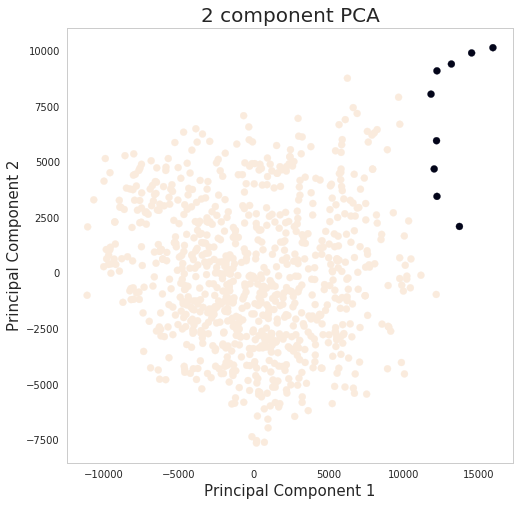

In [48]:
# 시각화 : 제거된 부분 확인
dbscan_plot(imgs_60_pca,clustering_60)

In [49]:
# 이상치 제거 전 data
print(len(change_Y_list))
print(len(dataset))

58291
58291


In [50]:
for idx in pop_list :
    change_Y_list.pop(idx)
    dataset.pop(idx)

In [51]:
# 이상치 제거 전 data
print(len(change_Y_list))
print(len(dataset))

57903
57903


# CNN Modeling

In [52]:
y = np.array(change_Y_list)

In [53]:
y.shape

(57903, 88)

In [54]:
data_set = np.array(dataset)

In [55]:
data_set.shape

(57903, 224, 224, 3)

In [57]:
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras import optimizers
from keras import backend as K
from keras.utils import to_categorical

/home/ubunt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [59]:
classifier = Sequential()

classifier.add(Conv2D(8, (3, 3), activation = 'relu',kernel_initializer='he_normal',input_shape = (224,224,3))) # 222 * 222
classifier.add(BatchNormalization())
classifier.add(Conv2D(8, (3, 3), activation = 'relu',kernel_initializer='he_normal')) # 220 * 220
classifier.add(BatchNormalization())
classifier.add(Conv2D(8, (3, 3), activation = 'relu',kernel_initializer='he_normal')) # 218 * 218
classifier.add(BatchNormalization())
classifier.add(Conv2D(8, (3, 3), activation = 'relu',kernel_initializer='he_normal')) # 216 * 216
classifier.add(BatchNormalization())

classifier.add(AveragePooling2D(pool_size = (216, 216)))

classifier.add(Flatten())
classifier.add(Dense(units = 88, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [60]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 8)       224       
_________________________________________________________________
batch_normalization_2 (Batch (None, 222, 222, 8)       32        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 220, 220, 8)       584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 220, 220, 8)       32        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 218, 218, 8)       584       
_________________________________________________________________
batch_normalization_4 (Batch (None, 218, 218, 8)       32        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 216, 216, 8)       584       
__________

In [61]:
classifier.fit(data_set,y, epochs=5, batch_size = 32)

Epoch 1/5
57903/57903 [==============================] - 287s 5ms/step - loss: 0.1651 - acc: 0.9744
Epoch 2/5
57903/57903 [==============================] - 258s 4ms/step - loss: 0.0881 - acc: 0.9791
Epoch 3/5
57903/57903 [==============================] - 257s 4ms/step - loss: 0.0859 - acc: 0.9791
Epoch 4/5
57903/57903 [==============================] - 258s 4ms/step - loss: 0.0840 - acc: 0.9791
Epoch 5/5
57903/57903 [==============================] - 258s 4ms/step - loss: 0.0829 - acc: 0.9791


In [62]:
classifier.save_weights("Adopt_ML.hd5")